In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

(128, 128)


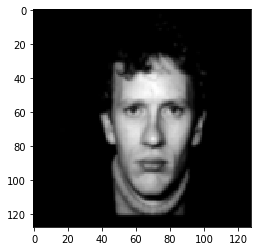

84


In [2]:
# 查看单个图片信息
# 2099-2106 全黑
f = open('./face/rawdata/2155','rb')
x = np.fromfile(f,dtype=np.ubyte)
x = x.reshape(128,-1)
# x = x[:,:500]
print(x.shape)
plt.imshow(x,cmap=plt.cm.gray)
plt.show()
f.close()
print(x[50,50])

In [3]:
all_file = os.listdir('./face/rawdata')
len(all_file)
all_file[876]

'2110'

In [4]:
# 读取所有data_x数据,  有问题的数据：第1186个，2412号；第1190个，2416号
data_x = np.zeros((len(all_file),128,128))
data_y = np.zeros(len(all_file))

In [5]:
# 将两个数据标签整理再一起
f = open('./face/faceDR','r')
r1 = f.readlines()
f.close()

f = open('./face/faceDS','r')
r2 = f.readlines()
f.close()
for i in r2:
    r1.append(i)

In [6]:
# 整理出data_x,和data_y
all_file = os.listdir('./face/rawdata')
for i in range(len(all_file)):
    with open('./face/rawdata/'+all_file[i],'rb') as f:
        x = np.fromfile(f,dtype=np.ubyte)
        x = x.reshape(128,-1)
        data_x[i] = x
        for j in r1:
            if all_file[i] in j:
                if 'female' in j:
                    data_y[i] = 0
                elif 'male' in j:
                    data_y[i] = 1
                else:
                    data_y[i] = None
                break

In [7]:
from sklearn.preprocessing import OneHotEncoder
data_y = data_y.reshape(-1,1)
enc = OneHotEncoder(categories='auto').fit(data_y)
data_y = enc.transform(data_y).toarray()
data_y.shape

d:\Study softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
d:\Study softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for

(3983, 2)

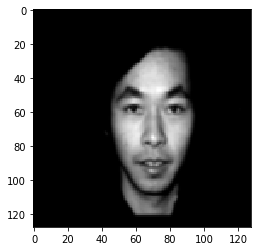

gender: [0. 1.]


In [8]:
# 查看数据集其中的图片和标签，[0,1]表示男，[1,0]表示女
# i = 876  有点问题
i = 1267
x = data_x[i]
y = data_y[i]
plt.imshow(x,cmap=plt.cm.gray)
plt.show()
print("gender:",y)

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import ssl
from torch import nn,optim
ssl._create_default_https_context = ssl._create_unverified_context
from torch.nn import functional as F

d:\Study softwares\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [10]:
# 分数据集
data_x = data_x.reshape(-1,1,128,128)
data_x.shape
X = torch.from_numpy(data_x)
Y = torch.from_numpy(data_y)

In [11]:
Xtrain,Xtest,Ytrain,Ytest = X[:3000],X[3000:],Y[:3000],Y[3000:]

In [19]:
Xtrain,Xval,Ytrain,Yval = X[:2000],X[2000:3000],Y[:2000],Y[2000:3000]
train_set = []
for i in range(len(Ytrain)):
    train_set.append((Xtrain[i],Ytrain[i]))
val_set =[]
for i in range(len(Yval)):
    val_set.append((Xval[i],Yval[i]))
batch_size = 16
# epochs = 10

set_train = torch.utils.data.DataLoader(train_set,batch_size = batch_size,shuffle=True)

set_val = torch.utils.data.DataLoader(val_set,batch_size = batch_size,shuffle=True)

In [29]:
data_set = []
for i in range(len(Y)):
    data_set.append((X[i],Y[i]))

In [30]:
train_set,test_set = torch.utils.data.random_split(data_set,[3000,983],generator=torch.Generator().manual_seed(0))
print("train_set:",len(train_set),"\ttest_set",len(test_set))

train_set: 3000 	test_set 983


In [31]:
batch_size = 16
set_test = torch.utils.data.DataLoader(test_set,batch_size = batch_size,shuffle=False)

In [16]:
# train_set = []
# for i in range(len(Ytrain)):
#     train_set.append((Xtrain[i],Ytrain[i]))
# test_set =[]
# for i in range(len(Ytest)):
#     test_set.append((Xtest[i],Ytest[i]))
def KfoldC_V(train_set,batch_size=16):
    set_train0,set_val0 = torch.utils.data.random_split(train_set,[2400,600],generator=torch.Generator().manual_seed(1))
    set_train = torch.utils.data.DataLoader(set_train0,batch_size = batch_size,shuffle=True)
    set_val = torch.utils.data.DataLoader(set_val0,batch_size = batch_size,shuffle=True)
    return set_train,set_val


# batch_size = 16
# epochs = 10

# set_train = torch.utils.data.DataLoader(train_set,batch_size = batch_size,shuffle=True)


# set_test = torch.utils.data.DataLoader(test_set,batch_size = batch_size,shuffle=False)




In [15]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [13]:
class VGGnet(nn.Module):

    def __init__(self):
        super(VGGnet,self).__init__()

        self.conv_unit = nn.Sequential(
            # x:[b,1,128,128] => [b,64,128,128]
            nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
            ,nn.ReLU()
            ,nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1)
            ,nn.ReLU()
            # [b,64,128,128] => [b,64,64,64]
            ,nn.MaxPool2d(kernel_size=2,stride=2)

            # [b,64,64,64] => [b,128,64,64]
            ,nn.Conv2d(64,128,kernel_size=3,stride = 1,padding=1)
            # ,nn.Conv2d(128,128,kernel_size=3,stride = 1,padding=1)
            ,nn.ReLU()
            # [b,128,64,64] => [b,128,32,32]
            ,nn.MaxPool2d(kernel_size=2,stride=2)

            # [b,128,32,32] => [b,256,32,32]
            ,nn.Conv2d(128,256,kernel_size=3,stride = 1,padding=1)
            ,nn.ReLU()
            
            # [b,256,32,32] => [b,256,16,16]
            ,nn.MaxPool2d(kernel_size=2,stride=2)
            
            # [b,256,16,16] => [b,256,16,16]
            ,nn.Conv2d(256,256,kernel_size=3,stride = 1,padding=1)
            ,nn.ReLU()
            ,nn.Conv2d(256,256,kernel_size=3,stride = 1,padding=1)
            ,nn.ReLU()

            # [b,256,16,16] => [b,256,8,8]
            ,nn.MaxPool2d(kernel_size=2,stride=2)

            # [b,256,8,8] => [b,256,8,8]
            ,nn.Conv2d(256,256,kernel_size=3,stride = 1,padding=1)
            ,nn.ReLU()
            ,nn.Conv2d(256,256,kernel_size=3,stride = 1,padding=1)
            ,nn.ReLU()
            # [b,256,8,8] => [b,256,4,4]
            ,nn.MaxPool2d(kernel_size=2,stride=2)
        )
        # flatten
        
        self.fc_unit = nn.Sequential(
            nn.Linear(256*4*4,256)
            ,nn.ReLU()
            ,nn.Linear(256,32)
            ,nn.ReLU()
            ,nn.Linear(32,2)
        )

        # tmp = torch.randn(1,1,128,128)
        # out = self.conv_unit(tmp)
        # print(out.shape)
        # # out = self.fc_unit(out)
        # # print(out.shape)
        # print(self.forward(tmp))

        # self.criteon = nn.CrossEntropyLoss()

    def forward(self,x):
        batchsz = x.size(0)
        # x:[b,1,128,128] => [b,256,4,4]
        x = self.conv_unit(x)
        # x:[b,256,4,4]=>[b,256*4*4]
        x = x.view(batchsz,-1)
        # x:[b,256*4*4] => [b,2]
        logits = self.fc_unit(x)
        return logits
        

In [19]:
# 单次训练
set_train,set_val = KfoldC_V(train_set)


In [18]:
kcv = []

In [17]:
import time
x,label = iter(set_train).next()
print('x:',x.shape,'label:',label.shape)

device = torch.device('cuda')
# 加载
net = VGGnet()
net = net.to(device)
net.load_state_dict(torch.load('vgg_face.mdl'))

criteon = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(),lr=1e-3)

print(net)
print("---------")
epochs = 1
# print("First fold Cross-Validation:")
for epoch in range(epochs):
    t1 = time.time()
    for batchidx,(x,label) in enumerate(set_train):
        # x:[b,1,128,128]
        # label [b,2]
        x,label = x.to(device),label.to(device)
        logits = net(x)
        # loss: tensor scalar
        # print("----------")
        # print(logits.shape)
        # print(label.shape)
        loss = criteon(logits,label)

        # backprop
        optimizer.zero_grad() # 优化器清零
        loss.backward()
        optimizer.step() # 更新

    print("Epoch {},Value of Loss function:{}".format(epoch,loss.item()))
    # loss_list.append(loss.item())
    
    net.eval()
    # 不需要构建计算图
    with torch.no_grad():
        # test
        total_correct = 0
        total_num = 0
        for x,label in set_val:
            x , label = x.to(device),label.to(device)
            logits = net(x)
            pred = logits.argmax(dim=1)
            # print(pred)
            total_correct += torch.eq(pred,label.argmax(dim=1)).float().sum().item()
            total_num += x.size(0)

        acc = total_correct /total_num
        
        print("\tAccuracy:{}".format(acc))
        kcv.append((loss.item(),acc))
        # print("run time:{:.4f}s".format(time.time()-t1))
        # acc_list.append(acc)
        

# torch.save(net.state_dict(),'vgg_face.mdl')


x: torch.Size([16, 1, 128, 128]) label: torch.Size([16, 2])
---------
First fold Cross-Validation:
Epoch 0,Value of Loss function:0.24637360868090513
	Accuracy:0.9267214150347441


NameError: name 'kcv' is not defined

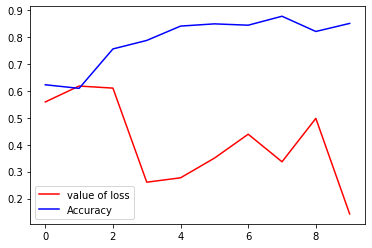

In [30]:
plt.plot(range(10),loss_list,"r-",label = "value of loss")
plt.plot(range(10),acc_list,"b-",label="Accuracy")
plt.legend()
plt.show()

In [20]:
# loss_list = [0.5594217496910439, 0.6186511689521352, 0.6108758524876543, 0.2608377960782303]
# acc_list = [0.6233333333333333, 0.61, 0.7566666666666667, 0.7883333333333333]
print(loss_list)
print(acc_list)


[0.5594217496910439, 0.6186511689521352, 0.6108758524876543, 0.2608377960782303]
[0.6233333333333333, 0.61, 0.7566666666666667, 0.7883333333333333]


In [19]:
# 测试集测试准确率
# device = torch.device('cuda')
# 加载
net = VGGnet()
# net = net.to(device)
net.load_state_dict(torch.load('vgg_face.mdl'))

total_correct = 0
total_num = 0
for x,label in set_test:
    # x , label = x.to(device),label.to(device)
    logits = net(x)
    pred = logits.argmax(dim=1)
    # print(pred)
    total_correct += torch.eq(pred,label.argmax(dim=1)).float().sum().item()
    total_num += x.size(0)

acc = total_correct /total_num
print("\tAccuracy:{}".format(acc))

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1207959552 bytes.

In [34]:
# loss_list = [0.5594217496910439, 0.6186511689521352, 0.6108758524876543, 0.2608377960782303, 0.27710860478885946, 0.35022169062181835, 0.43931085024761923, 0.336778627061013, 0.4982343486526473, 0.14273828220246879]
# acc_list = [0.6233333333333333, 0.61, 0.7566666666666667, 0.7883333333333333, 0.8416666666666667, 0.85, 0.845, 0.8783333333333333, 0.8216666666666667, 0.8516666666666667]
print(loss_list)
print(acc_list)

[0.5594217496910439, 0.6186511689521352, 0.6108758524876543, 0.2608377960782303, 0.27710860478885946, 0.35022169062181835, 0.43931085024761923, 0.336778627061013, 0.4982343486526473, 0.14273828220246879]
[0.6233333333333333, 0.61, 0.7566666666666667, 0.7883333333333333, 0.8416666666666667, 0.85, 0.845, 0.8783333333333333, 0.8216666666666667, 0.8516666666666667]


In [16]:
# 清空GPU内存
import gc

gc.collect()
torch.cuda.empty_cache()

In [45]:
Xtrain.shape

torch.Size([2000, 1, 128, 128])

In [44]:
Xtrain,Xval,Ytrain,Yval = torch.cat((X[0:1000],X[2000:3000]),dim=0),X[1000:2000],torch.cat((Y[0:1000],Y[2000:3000]),dim=0),Y[1000:2000]
train_set = []
for i in range(len(Ytrain)):
    train_set.append((Xtrain[i],Ytrain[i]))
val_set =[]
for i in range(len(Yval)):
    val_set.append((Xval[i],Yval[i]))
batch_size = 16
# epochs = 10

set_train = torch.utils.data.DataLoader(train_set,batch_size = batch_size,shuffle=True)

set_val = torch.utils.data.DataLoader(val_set,batch_size = batch_size,shuffle=True)

set_test = torch.utils.data.DataLoader(test_set,batch_size = batch_size,shuffle=False)

In [21]:
kcv=[]

In [46]:
# 交叉验证
import time
x,label = iter(set_train).next()
print('x:',x.shape,'label:',label.shape)

device = torch.device('cuda')
# 加载
net = VGGnet()
net = net.to(device)
net.load_state_dict(torch.load('vgg_face.mdl'))

criteon = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(),lr=1e-3)

# print(net)
print("---------")
epochs = 1
print("Third fold Cross-Validation:")
for epoch in range(epochs):
    t1 = time.time()
    for batchidx,(x,label) in enumerate(set_train):
        # x:[b,1,128,128]
        # label [b,2]
        x,label = x.to(device),label.to(device)
        logits = net(x)
        # loss: tensor scalar
        # print("----------")
        # print(logits.shape)
        # print(label.shape)
        loss = criteon(logits,label)

        # backprop
        optimizer.zero_grad() # 优化器清零
        loss.backward()
        optimizer.step() # 更新

    print("Value of Loss function:{}".format(loss.item()))
    # loss_list.append(loss.item())
    
    net.eval()
    # 不需要构建计算图
    with torch.no_grad():
        # test
        total_correct = 0
        total_num = 0
        for x,label in set_test:
            x , label = x.to(device),label.to(device)
            logits = net(x)
            pred = logits.argmax(dim=1)
            # print(pred)
            total_correct += torch.eq(pred,label.argmax(dim=1)).float().sum().item()
            total_num += x.size(0)

        acc = total_correct /total_num
        
        print("\tAccuracy:{}".format(acc))
        kcv.append((loss.item(),acc))
        # print("run time:{:.4f}s".format(time.time()-t1))
        # acc_list.append(acc)
        

# torch.save(net.state_dict(),'vgg_face.mdl')


x: torch.Size([16, 1, 128, 128]) label: torch.Size([16, 2])
---------
Third fold Cross-Validation:
Value of Loss function:0.1243118413689385
	Accuracy:0.8484231943031536


In [52]:
print("3 Fold Cross_Validation Average Accuracy:{:.4f} %".format(100*(acc+0.8413+0.842319)/3))

3 Fold Cross_Validation Average Accuracy:84.4014 %


In [19]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [22]:
# 加载
# net = Net()
# net.load_state_dict(torch.load('net01.mdl'))


In [33]:
def plot_image(img,label,name):
    fig = plt.figure()
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        plt.imshow(img[i][0]*0.3081+0.1307,cmap = "gray",interpolation='none')
        plt.title("{}:{}".format(name,label[i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()

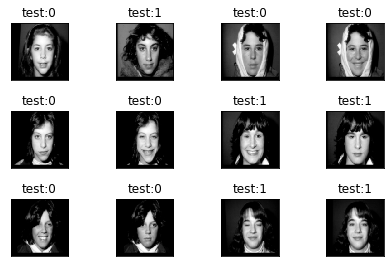

In [34]:
x,label = iter(set_test).next()
x ,label = x.to(device),label.to(device)
out = net(x.view(-1,1,128,128))
pred = out.argmax(dim = 1)
plot_image(x.cpu(),pred.cpu(),"test")

In [ ]:
# 保存和加载
net.load_state_dict(torch.load('net01.mdl'))
torch.save(net.state_dict(),'net01.mdl')